In [3]:
import sys
print(sys.version)
print(sys.path)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
['/home/jb/workspace/HLAVO/notebooks/Richards', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/jb/workspace/jupyter_notebooks/jupy-env/lib/python3.10/site-packages']


  0%|          | 0/72.0 [00:00<?, ?it/s]

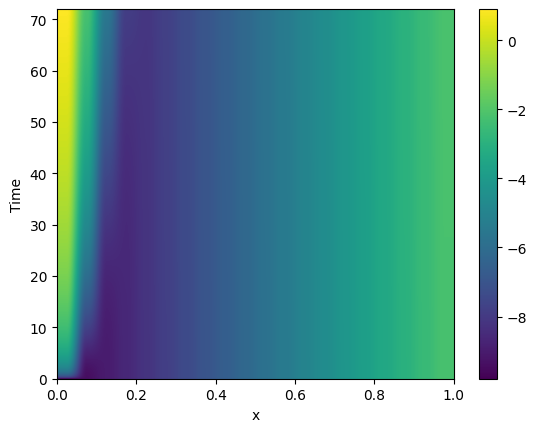

In [72]:
import pde
import numpy as np
import dataclasses

@dataclasses.dataclass
class Hydraulic:
    th_s: float      # porosity
    th_0: float      # residual water content
    k_s: float       # saturated hydraulic permeability [m/s]
    alpha: float      # inverse of entry pressure head [1/m]
    n: float         # Van Genuchten parameter

    @property
    def lmbd(self):
        return self.alpha
        
    def kr_h(self, h):
        H = np.minimum(0.0, h)
        return np.exp(self.lmbd * H)

    def mu_h(self, h):        
        return np.where(h < 0.0,
            np.exp(self.lmbd * h) / self.lmbd,
            1 / self.lmbd + h) 
        
    def h_mu(self, mu):
        return np.where(mu < 1/self.lmbd,
                        np.log(mu * self.lmbd)/self.lmbd,
                        mu - 1/self.lmbd)

@dataclasses.dataclass
class RichardsPDE(pde.PDEBase):
    hydraulic: Hydraulic
    flux_top: float  # boundary flux (positive = infiltration) [m/s]
    h_bot: float     # bottom pressure head [m]
    #relative saturation at bottom th = t_0 +(th_s - th_0) * th_r             

    @property
    def a(self):
        m = self.hydraulic
        return m.k_s/(m.th_s - m.th_0)/m.lmbd

    @property
    def b(self):
        m = self.hydraulic
        return m.k_s/(m.th_s - m.th_0)        

    @property
    def mu_bot(self):        
        return self.hydraulic.mu_h(self.h_bot)


    def evolution_rate(self, state, t=0):
        bc_top = {"type": "mixed", 
                  "value": - self.hydraulic.lmbd,
                 "const": self.flux_top / self.hydraulic.k_s}   
        # d_z mu + "value" * mu = "const"
        # TODO: Robin flux = D (th - TH) = in_flux = -K_s(d_z mu - lmbd * mu) 
        
        #bc_top = {"value": self.hydraulic.mu_h(-1)}
        bc_bot = {"value": self.mu_bot}
        bc = [bc_top, bc_bot]
        grad_z = state.gradient(bc=bc)[0]
        laplace_z = state.laplace(bc=bc)
        return self.a * laplace_z - self.b * grad_z


# Soil parameters accordin Rosseta model
# web: https://www.handbook60.org/rosetta/result
# python: https://github.com/usda-ars-ussl/rosetta-soil
# sand: 80%, silt 10%, clay 10%
sand = Hydraulic(
    th_s=0.38,
    th_0=0.05,
    k_s=77.7 * 0.01 / 24 / 3600, # [cm/d] -> [m/s]
    alpha=0.035 * 100,    # alpha [cm^{-1}] -> lmbd [m^{-1}]   
    n=1.6167)

# sand: 10%, silt 80%, clay 10%
silt = Hydraulic(
    th_s=0.47,
    th_0=0.06,
    k_s=30.8 * 0.01 / 24 / 3600, # [cm/d] -> [m/s]
    alpha=0.0058 * 100,    # alpha [cm^{-1}] -> lmbd [m^{-1}]   
    n = 1.6745)

model = silt

def h_from_mu(field):
    data = model.h_mu(field.data)
    #print(f"h_from_mu:\n {field.data}\n{data}\n")
    return pde.ScalarField(field.grid, data)

def mu_from_h(field):
    data = model.mu_h(field.data)
    #print(f"mu_from_h:\n {field.data}\n{data}\n")
    return pde.ScalarField(field.grid, data)


L = 1
z_step = 0.05
grid = pde.CartesianGrid([[0, L]], int(L / z_step))

init_h = pde.ScalarField.from_expression(grid, "-10*(1-x) + -2*x")
init_state = mu_from_h(init_h)
h_from_mu(init_state)

eq = RichardsPDE(
    hydraulic=model,
    flux_top=0.5 * 1e-3,   # 0.5 mm/h
    h_bot=-2
    )

storage = pde.MemoryStorage()
# time in hours
result = eq.solve(init_state, t_range=24*3, dt=0.01, method='scipy', 
                  tracker=["progress", storage.tracker(interval=0.1)])

# plot pressure head evolution
h_storage = storage.apply(h_from_mu)
pde.plot_kymograph(h_storage)
